In [206]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [207]:
class Dataset_Handler():
    
    def __init__(self, sequence, lidar=True, progress_bar=True, low_memory=True):
        
        self.lidar = lidar
        self.low_memory = low_memory
        
        self.seq_dir = '/home/logan_20/kitti_slam/dataset/sequences/{}/'.format(sequence)
        self.poses_dir = '/home/logan_20/kitti_slam/dataset/poses/{}.txt'.format(sequence)
        
        self.left_image_files = os.listdir(self.seq_dir + 'image_0')
        self.left_image_files.sort()
        self.right_image_files = os.listdir(self.seq_dir + 'image_1')
        self.right_image_files.sort()
        self.velodyne_files = os.listdir(self.seq_dir + 'velodyne')
        self.velodyne_files.sort()
        self.num_frames = len(self.left_image_files)
        self.lidar_path = self.seq_dir + 'velodyne/'
        
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        self.gt = np.zeros((self.num_frames, 3, 4))
        
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape(3,4)
        
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3, 4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3, 4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3, 4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3, 4))
        self.Tr = np.array(calib.loc['Tr:']).reshape((3, 4))
        
        if low_memory:
            self.reset_frames()
            self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[0], 0)
            self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                               + self.right_image_files[0], 0)
            self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[1], 0)
            if self.lidar:
                self.first_pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[0],
                                                    dtype=np.float32, count=-1).reshape((-1, 4))
            self.imheight = self.first_image_left.shape[0]
            self.imwidth = self.first_image_left.shape[1]
        
        else:
            self.images_left = []
            self.images_right = []
            self.pointclouds = []
            if progress_bar:
                import progressbar
                bar = progressbar.ProgressBar(max_value=self.num_frames)
            for i, name_left in enumerate(self.left_image_files):
                name_right = self.right_image_files[i]
                self.images_left.append(cv2.imread(self.seq_dir + 'image_0/' + name_left, 0))
                self.images_right.append(cv2.imread(self.seq_dir + 'image_1/' + name_right, 0))
                if self.lidar:
                    pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[i], 
                                            dtype=np.float32, count=-1).reshape((-1, 4))
                    self.pointclouds.append(pointcloud)
                if progress_bar:
                    bar.update(i+1)
                self.imheight = self.images_left[0].shape[0]
                self.imwidth = self.images_right[0].shape[1]
                    
            
    def reset_frames(self):
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        if self.lidar:
            self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, 
                                            dtype=np.float32, count=-1).reshape((-1, 4))
                                for velodyne_file in self.velodyne_files)
        pass

In [208]:
handler = Dataset_Handler('01')

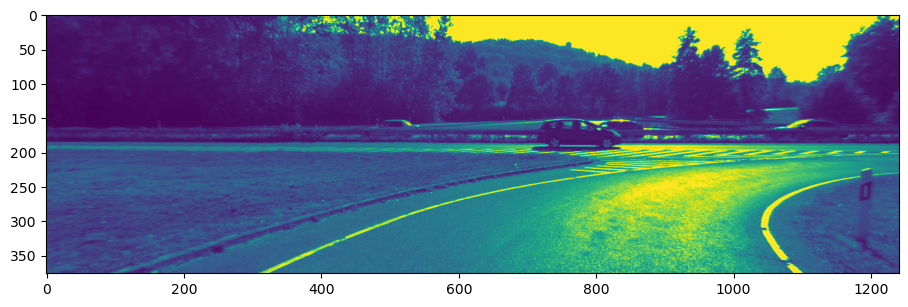

In [209]:
plt.figure(figsize=(11,7))
plt.imshow(handler.first_image_left);

In [210]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    '''
    Takes a left and right stereo pair of images and computes the disparity map for the left
    image. Pass rgb=True if the images are RGB.
    
    Arguments:
    img_left -- image from left camera
    img_right -- image from right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM matching
    rgb -- (bool) set to True if passing RGB images as input
    verbose -- (bool) set to True to report matching type and time to compute
    
    Returns:
    disp_left -- disparity map for the left camera image
    
    '''
    # Feel free to read OpenCV documentation and tweak these values. These work well
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left

Time to compute disparity map using StereoBM: 0:00:00.008396


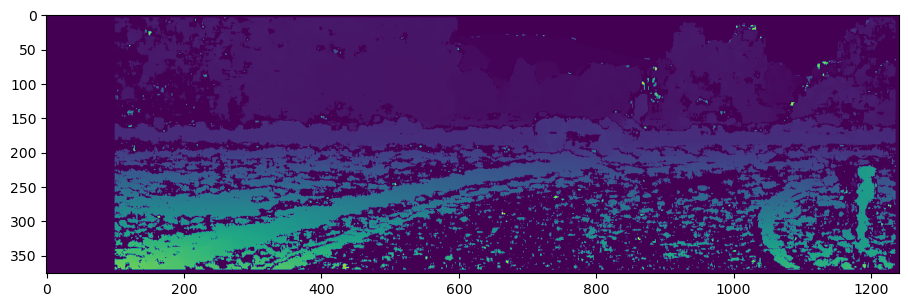

In [211]:
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

Time to compute disparity map using StereoSGBM: 0:00:00.020036


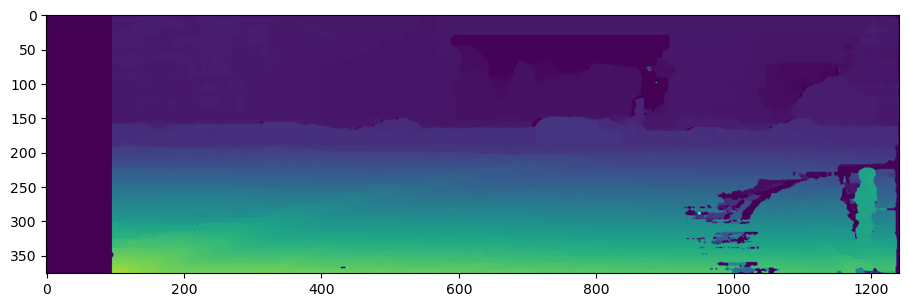

In [212]:
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

In [213]:
disp[0,0]

-1.0

In [214]:
def decompose_projection_matrix(p):
    '''
    Shortcut to use cv2.decomposeProjectionMatrix(), which only returns k, r, t, and divides
    t by the scale, then returns it as a vector with shape (3,) (non-homogeneous)
    
    Arguments:
    p -- projection matrix to be decomposed
    
    Returns:
    k, r, t -- intrinsic matrix, rotation matrix, and 3D translation vector
    
    '''
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    '''
    Calculate depth map using a disparity map, intrinsic camera matrix, and translation vectors
    from camera extrinsic matrices (to calculate baseline). Note that default behavior is for
    rectified projection matrix for right camera. If using a regular projection matrix, pass
    rectified=False to avoid issues.
    
    Arguments:
    disp_left -- disparity map of left camera
    k_left -- intrinsic matrix for left camera
    t_left -- translation vector for left camera
    t_right -- translation vector for right camera
    
    Optional Arguments:
    rectified -- (bool) set to False if t_right is not from rectified projection matrix
    
    Returns:
    depth_map -- calculated depth map for left camera
    
    '''
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [215]:
k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
k_right, r_right, t_right = decompose_projection_matrix(handler.P1)

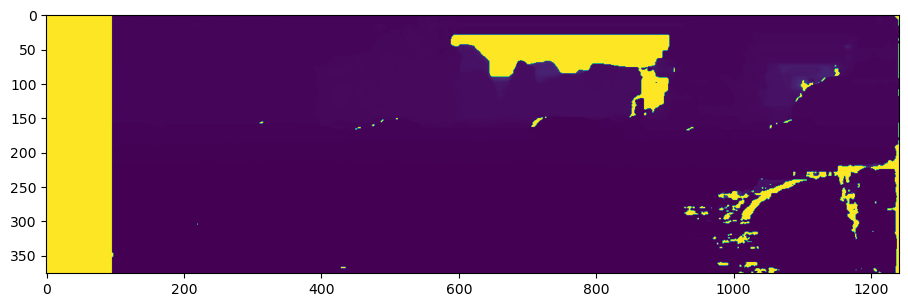

In [216]:
depth = calc_depth_map(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.imshow(depth);

In [217]:
depth[0,0]

3861.447942459941

In [218]:
depth.max()

3861.447942459941

In [219]:
k_left[0][0] * (t_right[0] - t_left[0]) / 0.1

array([3861.448])

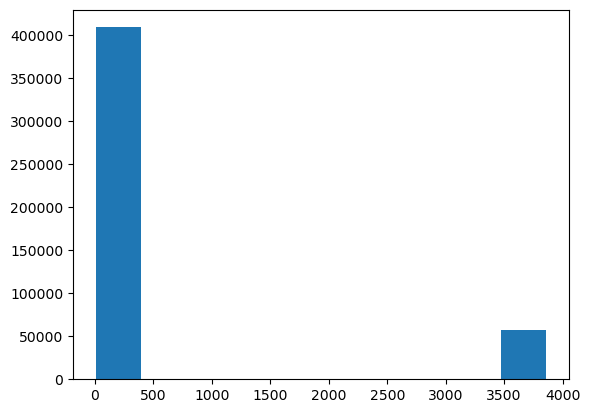

In [220]:
plt.hist(depth.flatten());

In [221]:
for i, pixel in enumerate(depth[4]):
    if pixel < depth.max():
        print('First non-max value at index', i)
        break

First non-max value at index 96


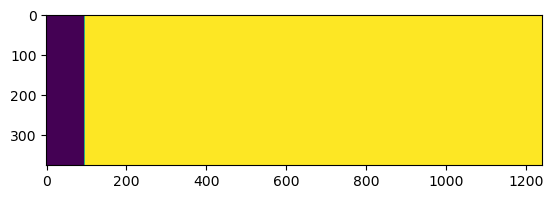

In [222]:
mask = np.zeros(handler.first_image_left.shape[:2], dtype=np.uint8)
ymax = handler.first_image_left.shape[0]
xmax = handler.first_image_left.shape[1]
cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask);

In [223]:
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False, 
                   rectified=True):
    '''
    Takes stereo pair of images and returns a depth map for the left camera. If your projection
    matrices are not rectified, set rectified=False.
    
    Arguments:
    img_left -- image of left camera
    img_right -- image of right camera
    P0 -- Projection matrix for the left camera
    P1 -- Projection matrix for the right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM
    rgb -- (bool) set to True if images passed are RGB. Default is False
    verbose -- (bool) set to True to report computation time and method
    rectified -- (bool) set to False if P1 not rectified to P0. Default is True
    
    Returns:
    depth -- depth map for left camera
    
    '''
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      rgb=rgb, 
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

In [224]:
def extract_features(image, detector='sift', mask=None):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [225]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    sort -- (bool) whether to sort matches by distance. Default is True
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [226]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [227]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

Time to compute disparity map using StereoSGBM: 0:00:00.019846


Number of matches before filtering: 1536
Number of matches after filtering: 436


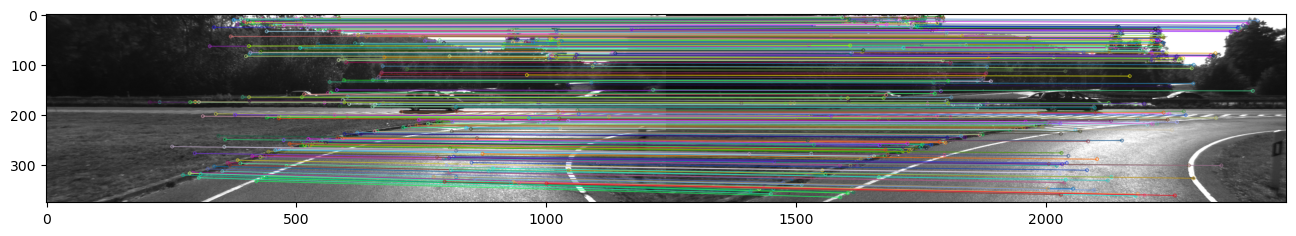

In [228]:
# Look at matched points using sgbm matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='sgbm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.5)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

Time to compute disparity map using StereoBM: 0:00:00.007590
Number of matches before filtering: 1536
Number of matches after filtering: 436


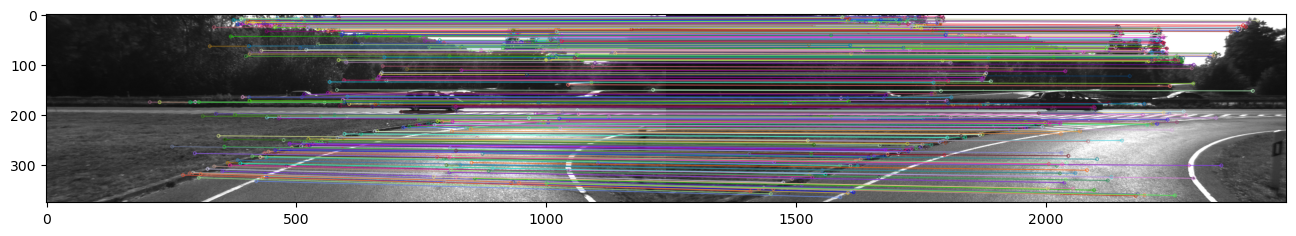

In [229]:
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='bm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.5)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

Time to compute disparity map using StereoBM: 0:00:00.008769
Number of matches before filtering: 500
Number of matches after filtering: 100


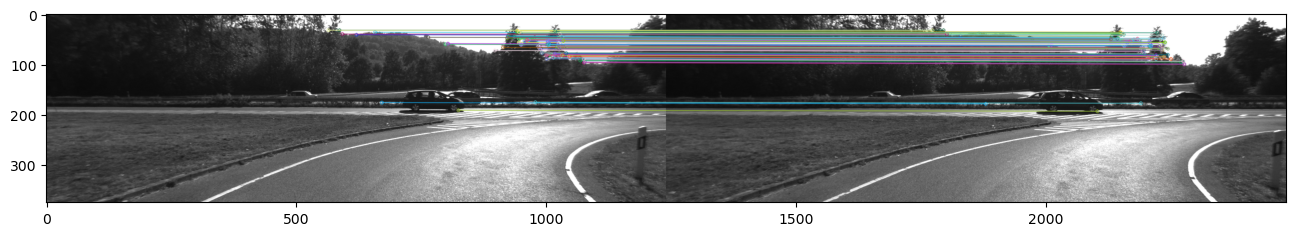

In [230]:
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='bm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'orb')
kp1, des1 = extract_features(image_plus1, 'orb')
matches = match_features(des0, des1, matching='BF', detector='orb', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.5)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

In [231]:
def pointcloud2image(pointcloud, imheight, imwidth, Tr, P0):
    '''
    Takes a pointcloud of shape Nx4 and projects it onto an image plane, first transforming
    the X, Y, Z coordinates of points to the camera frame with tranformation matrix Tr, then
    projecting them using camera projection matrix P0.
    
    Arguments:
    pointcloud -- array of shape Nx4 containing (X, Y, Z, reflectivity)
    imheight -- height (in pixels) of image plane
    imwidth -- width (in pixels) of image plane
    Tr -- 3x4 transformation matrix between lidar (X, Y, Z, 1) homogeneous and camera (X, Y, Z)
    P0 -- projection matrix of camera (should have identity transformation if Tr used)
    
    Returns:
    render -- a (imheight x imwidth) array containing depth (Z) information from lidar scan
    
    '''
    # We know the lidar X axis points forward, we need nothing behind the lidar, so we
    # ignore anything with a X value less than or equal to zero
    pointcloud = pointcloud[pointcloud[:, 0] > 0]
    
    # We do not need reflectance info, so drop last column and replace with ones to make
    # coordinates homogeneous for tranformation into the camera coordinate frame
    pointcloud = np.hstack([pointcloud[:, :3], np.ones(pointcloud.shape[0]).reshape((-1,1))])
    
    # Transform pointcloud into camera coordinate frame
    cam_xyz = Tr.dot(pointcloud.T)
    
    # Ignore any points behind the camera (probably redundant but just in case)
    cam_xyz = cam_xyz[:, cam_xyz[2] > 0]
    
    # Extract the Z row which is the depth from camera
    depth = cam_xyz[2].copy()
    
    # Project coordinates in camera frame to flat plane at Z=1 by dividing by Z
    cam_xyz /= cam_xyz[2]
    
    # Add row of ones to make our 3D coordinates on plane homogeneous for dotting with P0
    cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
    
    # Get pixel coordinates of X, Y, Z points in camera coordinate frame
    projection = P0.dot(cam_xyz)
    #projection = (projection / projection[2])
    
    # Turn pixels into integers for indexing
    pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')
    #pixel_coordinates = np.array(pixel_coordinates)
    
    # Limit pixel coordinates considered to those that fit on the image plane
    indices = np.where((pixel_coordinates[:, 0] < imwidth)
                       & (pixel_coordinates[:, 0] >= 0)
                       & (pixel_coordinates[:, 1] < imheight)
                       & (pixel_coordinates[:, 1] >= 0)
                      )
    pixel_coordinates = pixel_coordinates[indices]
    depth = depth[indices]
    
    # Establish empty render image, then fill with the depths of each point
    render = np.zeros((imheight, imwidth))
    for j, (u, v) in enumerate(pixel_coordinates):
        if u >= imwidth or u < 0:
            continue
        if v >= imheight or v < 0:
            continue
        render[v, u] = depth[j]
    # Fill zero values with large distance so they will be ignored. (Using same max value)
    render[render == 0.0] = 3861.45
    
    return render

Time to compute disparity map using StereoSGBM: 0:00:00.022934


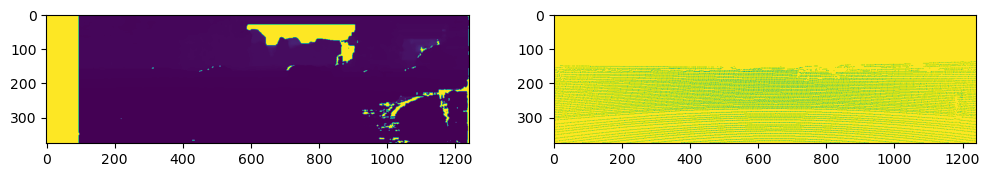

In [232]:
# Now a side-by-side comparison of the stereo depth vs lidar depth maps
depth_stereo = stereo_2_depth(image_left, 
                             image_right, 
                             handler.P0, 
                             handler.P1,
                             matcher='sgbm',
                             verbose=True)
depth_lidar = pointcloud2image(handler.first_pointcloud, handler.imheight, handler.imwidth,
                               handler.Tr, handler.P0
                              )
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.imshow(depth_stereo)
ax2.imshow(depth_lidar)

In [233]:
depth_lidar[depth_lidar < 3861.45].max()

78.53710277040051

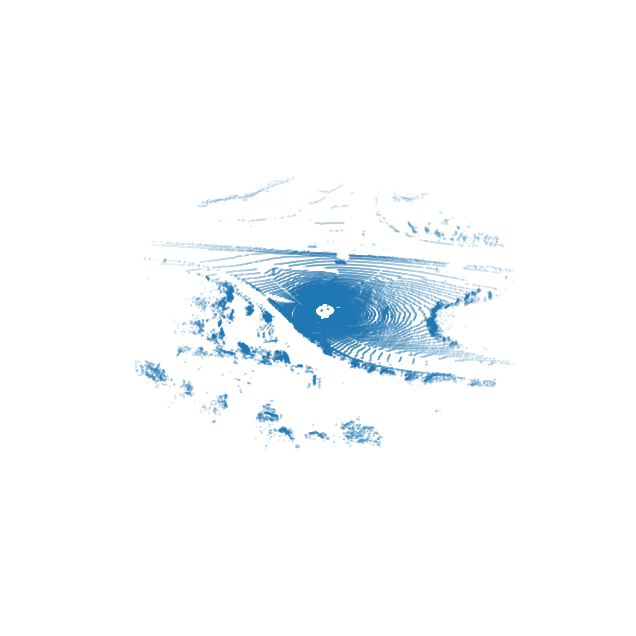

In [234]:
# Visualizing a lidar pointcloud with matplotlib.
pointcloud = handler.first_pointcloud
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

xs = pointcloud[:, 0]#[::20]   # Uncomment if 3d plot runs too slow, takes every 20th point
ys = pointcloud[:, 1]#[::20]
zs = pointcloud[:, 2]#[::20]

ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
ax.scatter(xs, ys, zs, s=0.01)
ax.grid(False)
ax.axis('off')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=40, azim=180)

In [235]:
# Let's determine the amount of image area that the lidar has given us depth information for
lidar_coverage = depth_lidar[depth_lidar < depth_lidar.max()].size / depth_lidar.size
print('Lidar Coverage: {}%'.format(np.round(lidar_coverage, 2)*100))

Lidar Coverage: 4.0%


In [236]:
idx_height, idx_width = np.where(depth_lidar < 3000)
depth_indx = np.array(list(zip(idx_height, idx_width)))

comparison = np.hstack([depth_stereo[depth_indx[:, 0], depth_indx[:, 1]].reshape(-1,1), 
                        depth_lidar[depth_indx[:, 0], depth_indx[:, 1]].reshape(-1,1)
                       ])
for i, row in enumerate(comparison):
    print('location:', depth_indx[i], 'stereo/lidar depth:', row)
    if i > 100:
        break

location: [ 138 1233] stereo/lidar depth: [77.22896    46.77907169]
location: [ 138 1237] stereo/lidar depth: [77.22896    46.38521948]
location: [ 139 1194] stereo/lidar depth: [64.35746667 44.42427186]
location: [ 139 1198] stereo/lidar depth: [64.35746667 44.15099761]
location: [ 139 1200] stereo/lidar depth: [64.35746667 44.09550263]
location: [ 139 1223] stereo/lidar depth: [75.34532683 49.31337675]
location: [ 139 1225] stereo/lidar depth: [75.34532683 46.73478906]
location: [ 139 1229] stereo/lidar depth: [76.27551605 46.46833081]
location: [ 140 1166] stereo/lidar depth: [64.35746667 45.31235606]
location: [ 140 1170] stereo/lidar depth: [63.69398763 45.10380842]
location: [ 140 1174] stereo/lidar depth: [63.69398763 46.73556486]
location: [ 140 1176] stereo/lidar depth: [64.35746667 45.39743494]
location: [ 140 1179] stereo/lidar depth: [64.35746667 44.99966415]
location: [ 140 1183] stereo/lidar depth: [64.35746667 44.48939854]
location: [ 140 1187] stereo/lidar depth: [64.35